Implementation of the paper：

- Wong, K.-F. & Wang, X.-J. A Recurrent Network Mechanism 
  of Time Integration in Perceptual Decisions. 
  J. Neurosci. 26, 1314–1328 (2006).

In [2]:
import brainpy as bp
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

print("version：", bp.__version__)

version： 0.3.4


In [3]:
def decision_model(coherence=0, tau_s=100., gamma=0.641,
                J_rec = .1561, J_inh = .0264,
                J_A11 = 9.9026e-04, J_A12 = 6.5177e-05, 
                J_Aext = 0.2243e-03,
                I_0=0.2346, noise = 1.,
                tau_A = 2.):
    '''
    Args:
        coherence (float): coherence level (from 0. to 1. => 0% to 100%).
        tau_s (float): NMDAR time constant.
        gamma (float): NMDAR dynamics parameters.
        J_rec (float): from self to self, NMDA; J_N11=J_N22
        J_inh (float): from others to self, NMDA; J_N21=J_N12
        J_A11 (float): from 1 to 1, AMPAR; J_A22=J_A11
        J_A12 (float): from 2 to 1, AMPAR; J_A21=J_A12
        J_Aext (float): average synaptic coupling with AMPARs.
        I_0 (float): mean effective external input.
        noise (flaot): variance of the noise.
        ----------
        tau_A (float): AMPAR time constant.
    '''
    ST = bp.types.NeuState('s1', 's2', 'r1', 'r2', 'input')

    def theta(x):
        return np.where(x< 0, 0, 1)

    @bp.integrate
    def int_s1(s1, t, s2, I_ext):
        I1 = J_Aext * (1 + coherence) * I_ext
        I2 = J_Aext * (1 - coherence) * I_ext
        x1 = J_rec * s1 - J_inh * s2 + I_0 + I1
        x2 = J_rec * s2 - J_inh * s1 + I_0 + I2
        # H(x1, x2)
        a = 239400 * J_A11 + 270
        b = 97000 * J_A11 + 108
        d = -30 * J_A11 + 0.1540
        f = J_A12 * (-276 * x2 + 106) * theta(x2 - 0.4)
        h1 = a * x1 - f - b
        r1 = h1 / (1 - np.exp(-d * h1))
        dsdt = - s1 / tau_s + (1 - s1) * gamma * r1
        return (dsdt, noise / tau_s), r1

    @bp.integrate
    def int_s2(s2, t, s1, I_ext):
        I1 = J_Aext * (1 + coherence) * I_ext
        I2 = J_Aext * (1 - coherence) * I_ext
        x1 = J_rec * s1 - J_inh * s2 + I_0 + I1
        x2 = J_rec * s2 - J_inh * s1 + I_0 + I2
        # H(x2, x1)
        a = 239400 * J_A11 + 270
        b = 97000 * J_A11 + 108
        d = -30 * J_A11 + 0.1540
        f = J_A12 * (-276 * x1 + 106) * theta(x1 - 0.4)
        h1 = a * x2 - f - b
        r2 = h1 / (1 - np.exp(-d * h1))
        dsdt = - s2 / tau_s + (1 - s2) * gamma * r2
        return (dsdt, noise / tau_s), r2

    def update(ST, _t):
        s1, ST['r1'] = int_s1(ST['s1'], _t, ST['s2'], ST['input'])
        ST['s2'], ST['r2'] = int_s2(ST['s2'], _t, ST['s1'], ST['input'])
        ST['s1'] = s1
        ST['input'] = 0.

    return bp.NeuType(name='neuron', 
                    ST=ST, 
                    steps=update, 
                    mode='scalar')

In [38]:
def decision_model2(coherence=0, tau_s=100., gamma=0.641,
                J_rec = .1561, J_inh = .0264,
                J_A11 = 9.9026e-04, J_A12 = 6.5177e-05, 
                J_Aext = 0.2243e-03,
                I_0=0.2346, noise = 1.,
                tau_A = 2.):
    '''
    Args:
        coherence (float): coherence level (from 0. to 1. => 0% to 100%).
        tau_s (float): NMDAR time constant.
        gamma (float): NMDAR dynamics parameters.
        J_rec (float): from self to self, NMDA; J_N11=J_N22
        J_inh (float): from others to self, NMDA; J_N21=J_N12
        J_A11 (float): from 1 to 1, AMPAR; J_A22=J_A11
        J_A12 (float): from 2 to 1, AMPAR; J_A21=J_A12
        J_Aext (float): average synaptic coupling with AMPARs.
        I_0 (float): mean effective external input.
        noise (flaot): variance of the noise.
        ----------
        tau_A (float): AMPAR time constant.
    '''
    ST = bp.types.NeuState('s1', 's2', 'r1', 'r2', 'input1','input2')

    def theta(x):
        return np.where(x< 0, 0, 1)

    @bp.integrate
    def int_s1(s1, t, s2, I1):
        x1 = J_rec * s1 - J_inh * s2 + I_0 + I1
        # H(x1, x2)
        a = 239400 * J_A11 + 270
        b = 97000 * J_A11 + 108
        d = -30 * J_A11 + 0.1540
        h1 = a * x1 - b
        r1 = h1 / (1 - np.exp(-d * h1))
        dsdt = - s1 / tau_s + (1 - s1) * gamma * r1
        return (dsdt, noise / tau_s), r1

    @bp.integrate
    def int_s2(s2, t, s1, I2):
        x2 = J_rec * s2 - J_inh * s1 + I_0 + I2
        # H(x2, x1)
        a = 239400 * J_A11 + 270
        b = 97000 * J_A11 + 108
        d = -30 * J_A11 + 0.1540
        h1 = a * x2 - b
        r2 = h1 / (1 - np.exp(-d * h1))
        dsdt = - s2 / tau_s + (1 - s2) * gamma * r2
        return (dsdt, noise / tau_s), r2

    def update(ST, _t):
        s1, ST['r1'] = int_s1(ST['s1'], _t, ST['s2'], ST['input1'])
        ST['s2'], ST['r2'] = int_s2(ST['s2'], _t, ST['s1'], ST['input2'])
        ST['s1'] = s1
        ST['input1'] = 0.
        ST['input2'] = 0.

    return bp.NeuType(name='neuron', 
                    ST=ST, 
                    steps=update, 
                    mode='scalar')

### Simulation

In [4]:
bp.profile.set(jit=False, dt=.1
                #numerical_method='exponential'
                )

decision_th = 15        # decision threshold (Hz).
coherence = .512               # coherence level (from 0. to 1. => 0% to 100%)

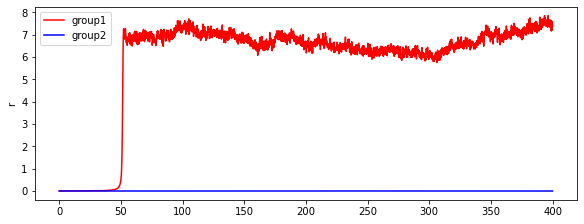

In [27]:
model = decision_model(coherence=coherence)
neu = bp.NeuGroup(model, 1, monitors=['r1', 'r2'])
neu.run(duration=400., inputs=('ST.input', 30.), report=False)

fig, gs = bp.visualize.get_figure(1, 1, 3, 8)

fig.add_subplot(gs[0, 0])

plt.plot(neu.mon.ts, neu.mon.r1[:,0], 'r', label = 'group1')
plt.plot(neu.mon.ts, neu.mon.r2[:,0], 'b', label = 'group2')
plt.ylabel('r')
plt.legend()
plt.show()

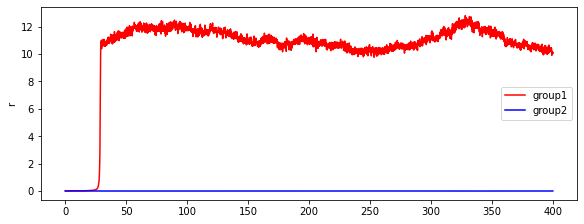

In [40]:
coherence = .512
I1, I2 = stimulus(coherence, mu0, 1.,JAext= 0.2243e-03)

model = decision_model2(coherence=coherence)
neu = bp.NeuGroup(model, 1, monitors=['r1', 'r2'])
neu.run(duration=400., inputs=(['ST.input1', I1],['ST.input2', I2]), report=False)

fig, gs = bp.visualize.get_figure(1, 1, 3, 8)

fig.add_subplot(gs[0, 0])

plt.plot(neu.mon.ts, neu.mon.r1[:,0], 'r', label = 'group1')
plt.plot(neu.mon.ts, neu.mon.r2[:,0], 'b', label = 'group2')
plt.ylabel('r')
plt.legend()
plt.show()

### Phase plane analysis

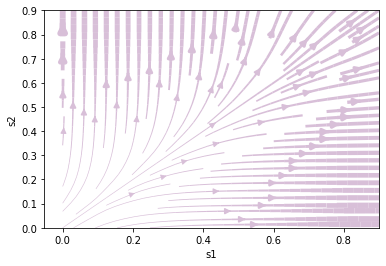

In [12]:
analyzer = bp.PhasePortraitAnalyzer(
    model=decision_model(coherence=coherence),
    target_vars=OrderedDict(s1=[0., 1.], s2=[0., 1.]),
    fixed_vars={'I_ext': 30.})

analyzer.plot_vector_field(show=True)

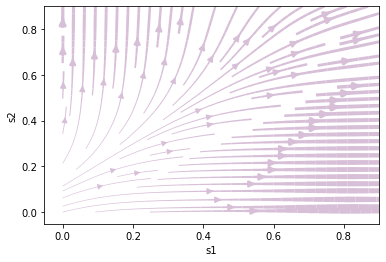

In [41]:
analyzer = bp.PhasePortraitAnalyzer(
    model=decision_model2(),
    target_vars=OrderedDict(s1=[0., 1.], s2=[0., 1.]),
    fixed_vars={'I1': I1, 'I2':I2})

analyzer.plot_vector_field(show=True)

### test

In [36]:
def stimulus(coh,mu0,ONOFF, JAext= 1):
    I1 = JAext * mu0 * (1 + coh) * ONOFF
    I2 = JAext * mu0 * (1 - coh) * ONOFF
    return I1, I2

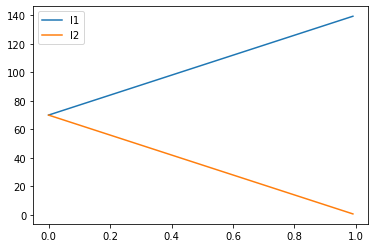

In [37]:
coherence = np.arange(0., 1., 0.01)
mu0 = 70.
I1, I2 = stimulus(coherence, mu0, 1.)
plt.plot(coherence, I1, label='I1')
plt.plot(coherence, I2, label='I2')
plt.legend()
plt.show()

2.1 0.7000000000000001


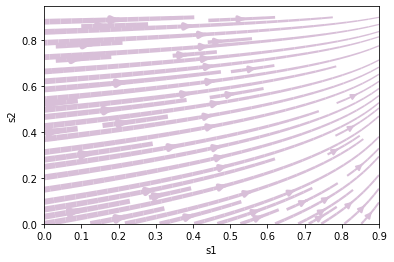

In [62]:
coherence=0.5
I1, I2 = stimulus(coherence, mu0, 1., JAext= 0.02)
print(I1, I2)

analyzer = bp.PhasePortraitAnalyzer(
    model=decision_model2(),
    target_vars=OrderedDict(s1=[0., 1.], s2=[0., 1.]),
    fixed_vars={'I1': I1, 'I2':I2})

analyzer.plot_vector_field(show=True)

0.21000000000000002 0.07


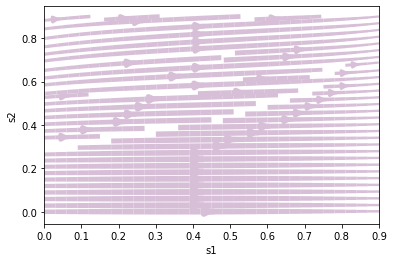

In [60]:
coherence=0.5
I1, I2 = stimulus(coherence, mu0, 1.,JAext= 0.002)
print(I1, I2)

analyzer = bp.PhasePortraitAnalyzer(
    model=decision_model2(),
    target_vars=OrderedDict(s1=[0., 1.], s2=[0., 1.]),
    fixed_vars={'I1': I1, 'I2':I2})

analyzer.plot_vector_field(show=True)

In [48]:
analyzer.plot_nullcline()

KeyboardInterrupt: 

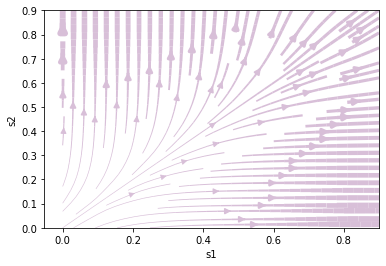

In [52]:
coherence=0.
I1, I2 = stimulus(coherence, mu0, 0.)

analyzer = bp.PhasePortraitAnalyzer(
    model=decision_model2(),
    target_vars=OrderedDict(s1=[0., 1.], s2=[0., 1.]),
    fixed_vars={'I1': I1, 'I2':I2})

analyzer.plot_vector_field(show=True)